# **I. Introduction**


Nama : Monica M. Pratiwi
<br>
Batch : FTDS-016-RMT





## **Query pada Google Cloud Platform**

Data yang digunakan adalah dataset `ml_datasets` dari database bernama `census_adult_income`.
<br>
Query yang dibuat memiliki kriteria sebagai berikut:
1. Kolom yang dipilih adalah `age`, `workclass`, `education`, `education_num`, `marital_status`, `occupation`, `relationship`, `race`, `sex`, `capital_gain`, `capital_loss`, `hours_per_week`, `native_country`, dan `income_bracket`.
2. Pilih semua `workclass`, kecuali `?`.
3. Pilih `hours_per_week` kurang dari 100.
4. Limit jumlah data menjadi sebanyak nomor batch dikali dengan tahun lahir. Untuk batch 16 dan lahir tahun 1998, maka nilai limit 16 x 1998 = 31968.

**Query yang digunakan**

In [2]:
# Insert Query

#select * except(functional_weight) from `bigquery-public-data.ml_datasets.census_adult_income`a
#where a.workclass not like '%?'
#and a.hours_per_week < 100
#limit 31968


## **Objective**

Membuat model classification menggunakan Logistic Regression dan SVM untuk memprediksi `income bracket`

# **II. Import Libraries**

In [3]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import array 
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import joblib
import json

In [5]:
!pip install feature-engine

from feature_engine.outliers import Winsorizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 276 kB 4.2 MB/s 


# **III. Data Loading**

Data yang sudah dipilih kemudian disimpan dengan nama `h8dsft_P1G2_monica_pratiwi` dalam format .csv di Google Drive. Selanjutnya, dibuat dataframe menggunakan data tersebut dengan nama `data`. 

In [6]:
# Loading Dataset

data = pd.read_csv('/content/drive/MyDrive/bq-results-20221109-120149-1667995351434/h8dsft_P1G2_monica_pratiwi.csv')



Data yang sudah terpanggil kemudian diperlihat 5 baris awal dan 5 baris akhir nya.

In [7]:
# Show the head of the data

data.head(5)


,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,18,Never-worked,Some-college,10,Never-married,?,Own-child,White,Male,0,0,4,United-States,<=50K
1,37,Private,12th,8,Married-civ-spouse,Sales,Wife,Asian-Pac-Islander,Female,0,0,33,?,<=50K
2,39,Self-emp-not-inc,HS-grad,9,Married-civ-spouse,Sales,Wife,Black,Female,0,0,54,Dominican-Republic,>50K
3,29,Private,HS-grad,9,Married-civ-spouse,Sales,Wife,White,Female,0,0,18,United-States,<=50K
4,64,Private,HS-grad,9,Married-civ-spouse,Sales,Wife,White,Female,0,0,21,United-States,<=50K


In [8]:
# Show the tail of the data

data.tail(5)

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
30720,50,Self-emp-inc,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,70,Germany,<=50K
30721,21,Private,Some-college,10,Never-married,Machine-op-inspct,Own-child,White,Female,0,0,70,United-States,<=50K
30722,32,Private,Some-college,10,Separated,Machine-op-inspct,Unmarried,Black,Female,0,0,70,United-States,<=50K
30723,39,Private,HS-grad,9,Divorced,Machine-op-inspct,Not-in-family,Black,Female,0,0,70,United-States,<=50K
30724,20,Private,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,70,United-States,<=50K


Sekilas terlihat ada 14 kolom dan 30725. Untuk mematikannya, dilakukan pengecekan bentuk dan ukuran dataset.

In [9]:
# Find the data shape

print('data shape : ', data.shape)
print('data size  : ', data.size)

data shape :  (30725, 14)
data size  :  430150


Jumlah baris dan kolom sesuai dengan pengamatan awal dan ukuran data merupakan hasil perkalian antara kolom dan baris yaitu terdapat 430150 informasi yang tersedia dalam data ini.
<br>
<br>
Selanjutnya, dilakukan pemeriksaan data.

In [10]:
# Check Dataset - 1

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30725 entries, 0 to 30724
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             30725 non-null  int64 
 1   workclass       30725 non-null  object
 2   education       30725 non-null  object
 3   education_num   30725 non-null  int64 
 4   marital_status  30725 non-null  object
 5   occupation      30725 non-null  object
 6   relationship    30725 non-null  object
 7   race            30725 non-null  object
 8   sex             30725 non-null  object
 9   capital_gain    30725 non-null  int64 
 10  capital_loss    30725 non-null  int64 
 11  hours_per_week  30725 non-null  int64 
 12  native_country  30725 non-null  object
 13  income_bracket  30725 non-null  object
dtypes: int64(5), object(9)
memory usage: 3.3+ MB


Dari 14 kolom, terdapat 5 kolom dengan jenis data integer dan sisanya adalah object. Sekilas tidak terlihat adanya missing values, namun pada pemeriksaan 5 baris awal ditemukan nilai '?' pada beberapa kolom yang mengindikasikan nilai data tidak diketahui atau dalam kata lain merupakan missing value.

In [11]:
# Duplicate data

data_2 = data.copy()

Selanjutnya, dilakukan penggandaan data agar ada data cadangan jika terjadi masalah pada data. Data cadangan diberi nama `data_2`.

In [12]:
# Check Dataset - 2
data.describe()

,age,education_num,capital_gain,capital_loss,hours_per_week
count,30725.000000,30725.000000,30725.000000,30725.000000,30725.000000
mean,38.439512,10.129699,1105.785094,88.889959,40.946461
std,13.119665,2.562702,7497.027762,405.613208,11.987385
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


Selanjutnya, dilakukan pemeriksaan data lainnya. Diketahui bahwa rata-rata penduduk berada dalam usia produktif. Penduduk rata-rata memiliki pendidikan terakhir setingkat *college*. Jumlah jam kerja dalam seminggu rata-rata 40 jam.

# **IV. Exploratory Data Analysis (EDA)**

In [13]:
# Function to create histogram and boxplot.

def diagnostic_plots(df, variable):
    # Define figure size
    plt.figure(figsize=(16, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], kde=True, bins=30)
    plt.title('Histogram')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

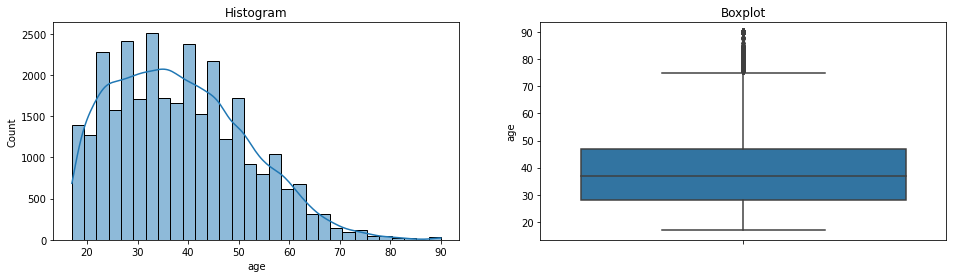


Skewness Value :  0.5316675402543493


In [14]:
# Distribution of variable `age`

diagnostic_plots(data, 'age')
print('\nSkewness Value : ', data['age'].skew())

Terdapat beberapa penduduk berusia di atas 70 tahun yang sudah memasuki usia pensiun jumlahnya paling sedikit diantara usia lainnya. Rata-rata penduduk berusia 38 tahun yang merupakan usia angkatan kerja.

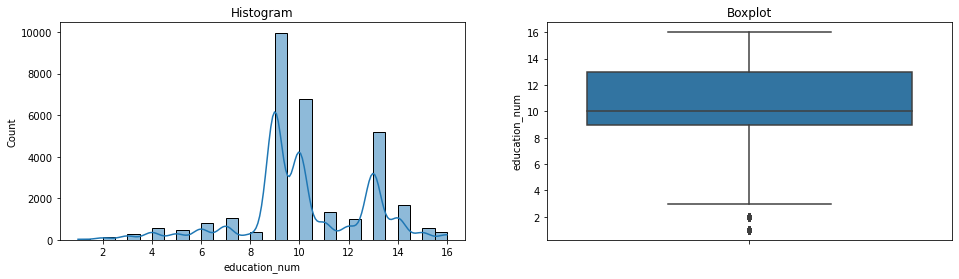


Skewness Value :  -0.31025823520678597


In [15]:
# Distribution of variable `education_num`

diagnostic_plots(data, 'education_num')
print('\nSkewness Value : ', data['education_num'].skew())

Kebanyakan penduduk merupakan lulusan Sekolah Menengah Atas.

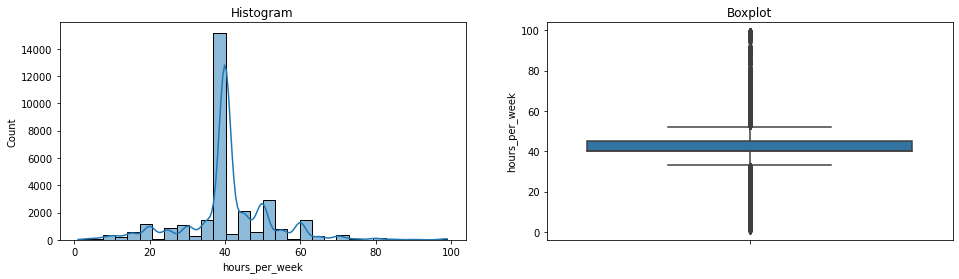


Skewness Value :  0.3307490496608131


In [16]:
diagnostic_plots(data, 'hours_per_week')
print('\nSkewness Value : ', data['hours_per_week'].skew())

Mayoritas penduduk bekerja selama 40 jam per minggu atau 8 jam sehari jika hari Sabtu dan Minggu tidak bekerja yang kemungkinannya adalah pekerjaan 9-5.

Selanjutnya, akan dicaritahu pekerjaan yang paling banyak digeluti oleh penduduk

In [17]:

data_occu=data['occupation'].value_counts()

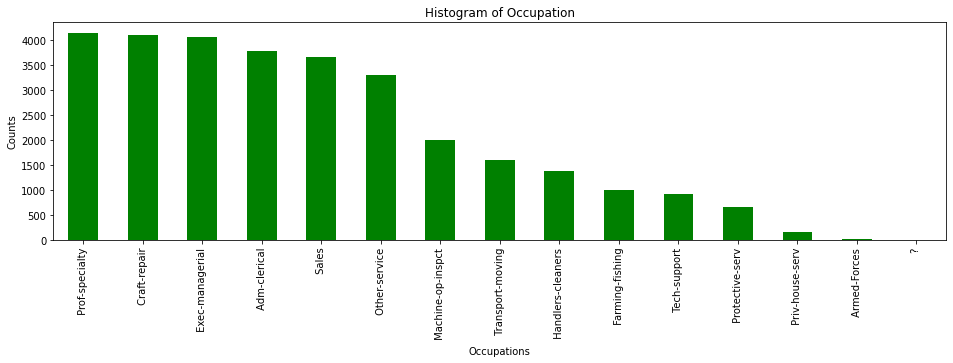

In [18]:
data_occu.plot(kind='bar', figsize=(16, 4), color='green')

plt.title('Histogram of Occupation') 
plt.ylabel('Counts') 
plt.xlabel('Occupations') 

plt.show()

In [19]:
data.groupby(["education_num", "education"]).size()

education_num  education    
1               Preschool         46
2               1st-4th          156
3               5th-6th          303
4               7th-8th          574
5               9th              463
6               10th             833
7               11th            1057
8               12th             393
9               HS-grad         9969
10              Some-college    6777
11              Assoc-voc       1321
12              Assoc-acdm      1020
13              Bachelors       5182
14              Masters         1675
15              Prof-school      558
16              Doctorate        398
dtype: int64

Kolom `education_num` melambangkan perkiraan jumlah tahun berdasarkan pendidikan yang ditempuh sehingga `education_num` sendiri sudah cukup untuk merepresentasikan tingkat pendidikan. Agar model berjalan lebih efektif maka kolom `education` akan dihapus.

In [20]:
# Remove column `education`
data.drop("education", inplace=True, axis=1)

# **V. Data Preprocessing**

In [21]:
# Get data for model inference

data_inference = data.sample(15, random_state=63)

In [22]:
# Remove inference set from dataset

data_train_test = data.drop(data_inference.index)

In [23]:
# Reset Index

data_train_test.reset_index(drop=True, inplace=True)
data_inference.reset_index(drop=True, inplace=True)

## **Splitting Between X (Feature) and y (Target)**

In [24]:
# Splitting between `X ` AND `y`

X = data_train_test.drop(['income_bracket'], axis=1) 
y = data_train_test['income_bracket']
X.head()

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
0,18,Never-worked,10,Never-married,?,Own-child,White,Male,0,0,4,United-States
1,37,Private,8,Married-civ-spouse,Sales,Wife,Asian-Pac-Islander,Female,0,0,33,?
2,39,Self-emp-not-inc,9,Married-civ-spouse,Sales,Wife,Black,Female,0,0,54,Dominican-Republic
3,29,Private,9,Married-civ-spouse,Sales,Wife,White,Female,0,0,18,United-States
4,64,Private,9,Married-civ-spouse,Sales,Wife,White,Female,0,0,21,United-States


In [25]:
# Splitting between Train-Set dengan Test-Set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
print('Train Size: ', X_train.shape)
print('Test Size: ', X_test.shape)

Train Size:  (24568, 12)
Test Size:  (6142, 12)


## **Handling Outlier**

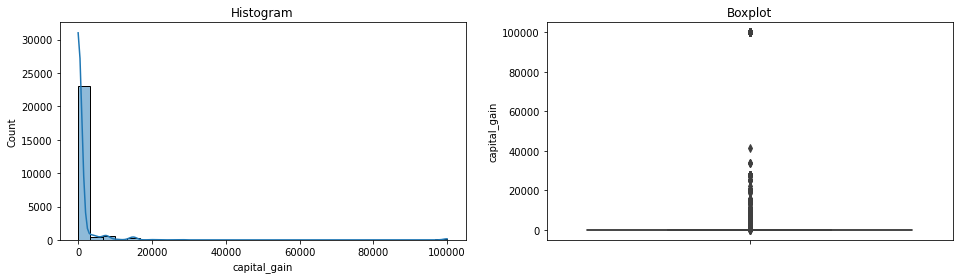


Skewness Value :  12.050557801737108


In [26]:
#Histogram and Boxplot for `capital_gain`
diagnostic_plots(X_train, 'capital_gain')
print('\nSkewness Value : ', X_train['capital_gain'].skew())

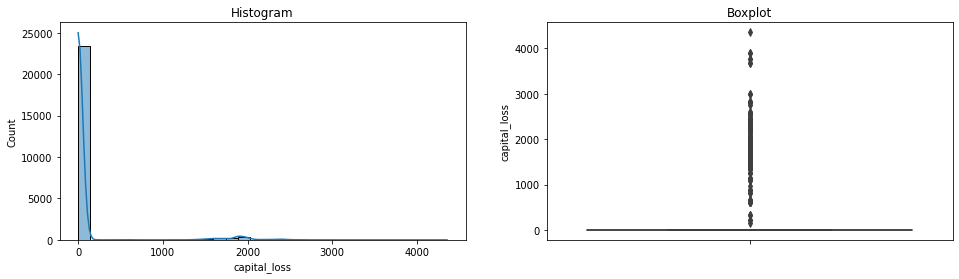


Skewness Value :  4.489830569790805


In [27]:
# Histogram and Boxplot for `capital_loss`
diagnostic_plots(X_train, 'capital_loss')
print('\nSkewness Value : ', X_train['capital_loss'].skew())

Data `capital_gain` dan `capital_loss` termasuk data yang memiliki outlier yang tinggi. Akan dihitung nilai batas atas dan bawahnya.

In [28]:
# Function to find upper and lower boundaries for skewed distributed variables

def find_skewed_boundaries(df, variable, distance):
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

In [29]:
# Boundaries IQR * 1.5, for `capital_gain` in the X_train dataset
capital_gain_upper_boundary, capital_gain_lower_boundary = find_skewed_boundaries(X_train, 'capital_gain', 1.5)
capital_gain_upper_boundary, capital_gain_lower_boundary

# Boundaries IQR * 1.5, for `capital_loss` in the X_train dataset
capital_loss_upper_boundary, capital_loss_lower_boundary = find_skewed_boundaries(X_train, 'capital_loss', 1.5)
capital_loss_upper_boundary, capital_loss_lower_boundary


print('capital_gain_upper_boundary : ', capital_gain_upper_boundary)
print('capital_gain_lower_boundary : ', capital_gain_lower_boundary, '\n')
print('capital_loss_upper_boundary : ', capital_loss_upper_boundary)
print('capital_loss_lower_boundary : ', capital_loss_lower_boundary, '\n')



capital_gain_upper_boundary :  0.0
capital_gain_lower_boundary :  0.0 

capital_loss_upper_boundary :  0.0
capital_loss_lower_boundary :  0.0 



Batas atas dan batas bawahnya adalah 0. Hal tersebut wajar karena tidak semua orang memiliki aset finansial yang dapat digunakan untuk inveatasi baik jangka pendek maupun panjang.
<br>
Nilai outlier pada kolom `age`, `education_num`, dan `hours_per_week` selanjutnya akan disensor (capping) menggunakan Winsorizer.

In [30]:
# Create the capper

winsorize = Winsorizer(capping_method='iqr', # choose iqr for IQR rule boundaries or gaussian for mean and std
                          tail='both', # cap left, right or both tails 
                          fold=1.5,
                          variables=['age', 'education_num', 'hours_per_week'])

winsorize.fit(X_train)

X_train_cap = winsorize.transform(X_train)
X_test_cap = winsorize.transform(X_test)

In [31]:
# Inspect the minimum caps for each variable
print('Left Tail Caps  : ', winsorize.left_tail_caps_)

# Iinspect the maximum caps for each variable
print('Right Tail Caps : ', winsorize.right_tail_caps_)

Left Tail Caps  :  {'age': -0.5, 'education_num': 3.0, 'hours_per_week': 32.5}
Right Tail Caps :  {'age': 75.5, 'education_num': 19.0, 'hours_per_week': 52.5}


In [32]:
print('X_train - Before Capping')
print(X_train.describe())
print('')
print('X_train - After Capping')
print(X_train_cap.describe())
print('')
print('')
print('X_test - Before Capping')
print(X_test.describe())
print('')
print('X_test - After Capping')
print(X_test_cap.describe())

X_train - Before Capping
                age  education_num  capital_gain  capital_loss  hours_per_week
count  24568.000000   24568.000000  24568.000000  24568.000000    24568.000000
mean      38.414319      10.136519   1071.052385     90.318015       40.873779
std       13.107015       2.559681   7305.343391    409.120613       12.011385
min       17.000000       1.000000      0.000000      0.000000        1.000000
25%       28.000000       9.000000      0.000000      0.000000       40.000000
50%       37.000000      10.000000      0.000000      0.000000       40.000000
75%       47.000000      13.000000      0.000000      0.000000       45.000000
max       90.000000      16.000000  99999.000000   4356.000000       99.000000

X_train - After Capping
                age  education_num  capital_gain  capital_loss  hours_per_week
count  24568.000000   24568.000000  24568.000000  24568.000000    24568.000000
mean      38.380637      10.144334   1071.052385     90.318015       41.398140
st

Age in `X_train` - Before Capping


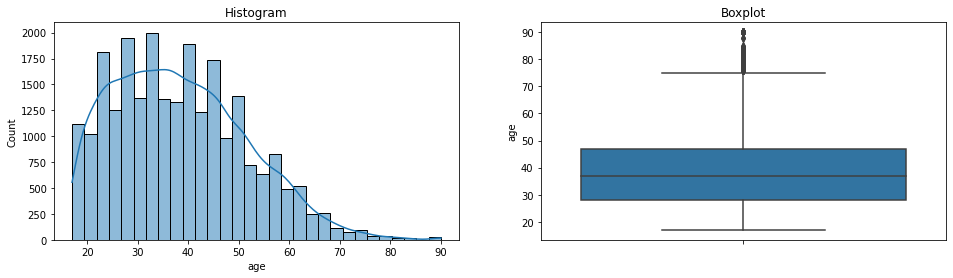

Skewness Value :  0.5326053324001083 


Age in `X_train` - After Capping


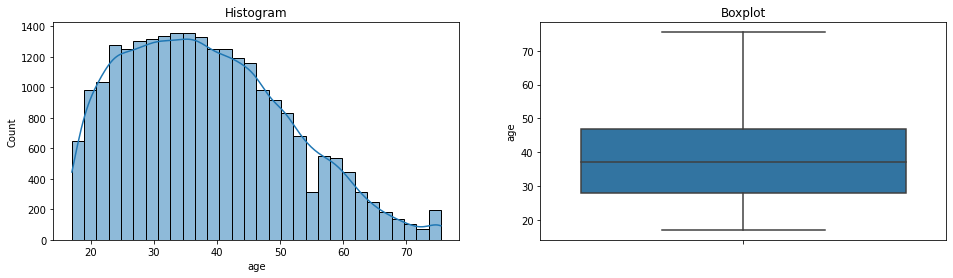

Skewness Value :  0.4710701903845404


In [33]:
print('Age in `X_train` - Before Capping')
diagnostic_plots(X_train, 'age')
print('Skewness Value : ', X_train['age'].skew(), '\n')
print('')
print('Age in `X_train` - After Capping')
diagnostic_plots(X_train_cap, 'age')
print('Skewness Value : ', X_train_cap['age'].skew())


Estimated Year of Education in `X_train` - Before Capping


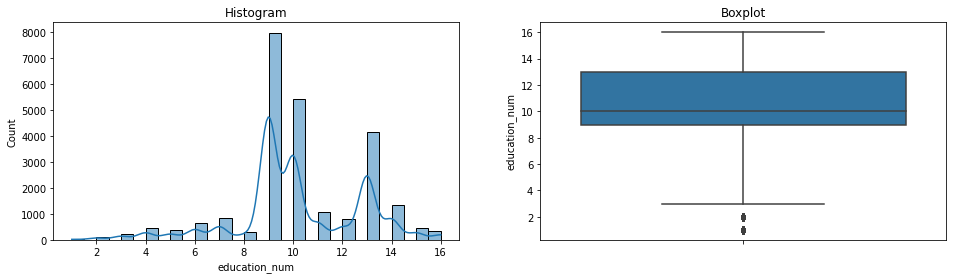

Skewness Value :  -0.30153958978674766 


Estimated Year of Education in `X_train` - After Capping


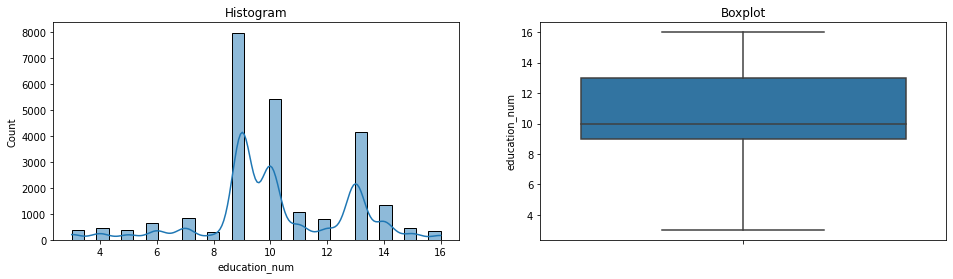

Skewness Value :  -0.23128935499320247


In [34]:
print('Estimated Year of Education in `X_train` - Before Capping')
diagnostic_plots(X_train, 'education_num')
print('Skewness Value : ', X_train['education_num'].skew(), '\n')
print('')
print('Estimated Year of Education in `X_train` - After Capping')
diagnostic_plots(X_train_cap, 'education_num')
print('Skewness Value : ', X_train_cap['education_num'].skew())


Hours per Week of Work in `X_train` - Before Capping


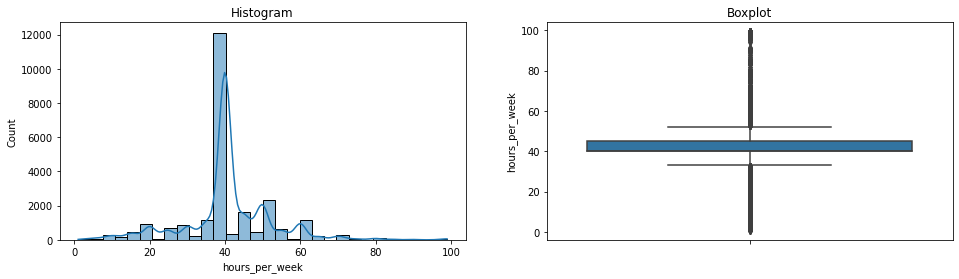


Skewness Value :  0.3106727361168121 


Hours per Week of Work in `X_train` - After Capping


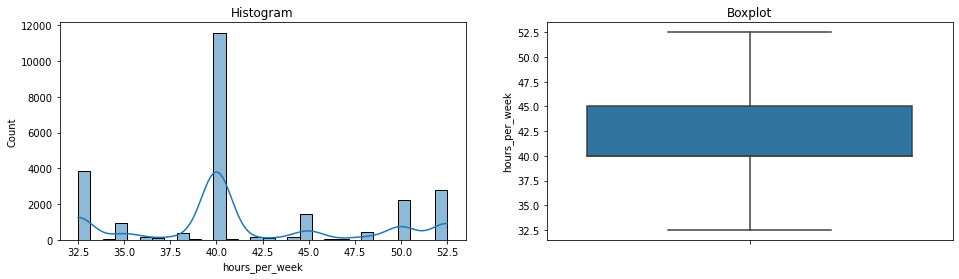

Skewness Value :  0.41811980385803266


In [35]:
print('Hours per Week of Work in `X_train` - Before Capping')
diagnostic_plots(X_train, 'hours_per_week')
print('\nSkewness Value : ', X_train['hours_per_week'].skew(), '\n')
print('')
print('Hours per Week of Work in `X_train` - After Capping')
diagnostic_plots(X_train_cap, 'hours_per_week')
print('Skewness Value : ', X_train_cap['hours_per_week'].skew())


Tiga kolom dengan outlier telah dilakukan capping dan persebaran data sudah normal.

## **Handling Missing Values**

In [36]:
X_train_cap.isna().sum()

age               0
workclass         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
dtype: int64

In [37]:
X_test.isna().sum()

age               0
workclass         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
dtype: int64

In [38]:
y_train.isna().sum()

0

In [39]:
y_test.isna().sum()

0

Nilai '?' tidak terdeteksi sebagai missing value. Hal tersebut kemungkinan karena adanya karakter yang tersembunyi.

## **Split Columns**

In [40]:
# Get Numerical Columns and Categorical Columns

numerical = X_train_cap.select_dtypes(include=np.number).columns.tolist()
categorical = X_train_cap.select_dtypes(include=['object']).columns.tolist()

print('Numerical Columns   : ', numerical)
print('Categorical Columns : ', categorical)

Numerical Columns   :  ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
Categorical Columns :  ['workclass', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']


In [41]:
# Split Train-Set and Test-Set based on Column Types

X_train_num = X_train_cap[numerical]
X_test_num = X_test[numerical]

X_train_cat = X_train_cap[categorical]
X_test_cat = X_test[categorical]

X_train_num.head(5)

,age,education_num,capital_gain,capital_loss,hours_per_week
20818,26.0,9.0,0,0,40.0
18478,35.0,13.0,0,0,40.0
19972,51.0,9.0,0,0,40.0
18900,19.0,10.0,0,0,40.0
12493,44.0,11.0,7688,0,40.0


## **Feature Selection**

## **Feature Scaling & Feature Encoding**

In [42]:
# prepare input data
scaler = MinMaxScaler()
X_train_num_enc = scaler.fit_transform(X_train_num)
X_test_num_enc = scaler.transform(X_test_num)
X_train_num_enc

array([[0.15384615, 0.46153846, 0.        , 0.        , 0.375     ],
       [0.30769231, 0.76923077, 0.        , 0.        , 0.375     ],
       [0.58119658, 0.46153846, 0.        , 0.        , 0.375     ],
       ...,
       [0.22222222, 0.61538462, 0.        , 0.        , 0.375     ],
       [0.23931624, 0.53846154, 0.        , 0.        , 0.875     ],
       [0.17094017, 0.76923077, 0.        , 0.        , 1.        ]])

In [43]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_train_cat_enc = ohe.fit_transform(X_train_cat)
X_test_cat_enc = ohe.transform(X_test_cat)
X_train_cat_enc

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [44]:
b = ohe.get_feature_names_out()

## **Concate between Numerical Columns and Categorical Columns**

In [45]:
X_train_final = np.concatenate([X_train_num_enc, X_train_cat_enc], axis=1)
X_test_final = np.concatenate([X_test_num_enc, X_test_cat_enc], axis=1)
X_train_final

array([[0.15384615, 0.46153846, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.30769231, 0.76923077, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.58119658, 0.46153846, 0.        , ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.22222222, 0.61538462, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.23931624, 0.53846154, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.17094017, 0.76923077, 0.        , ..., 1.        , 0.        ,
        0.        ]])

In [46]:
# Create DataFrame of `X_train_final`

X_train_final_df = pd.DataFrame(X_train_final)
X_train_final_df

,0,1,2,3,4,5,6,7,8,9,...,79,80,81,82,83,84,85,86,87,88
0,0.153846,0.461538,0.000000,0.0,0.375,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.307692,0.769231,0.000000,0.0,0.375,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.581197,0.461538,0.000000,0.0,0.375,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.034188,0.538462,0.000000,0.0,0.375,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.461538,0.615385,0.076881,0.0,0.375,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24563,0.239316,0.538462,0.000000,0.0,0.000,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
24564,0.427350,0.461538,0.000000,0.0,0.375,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
24565,0.222222,0.615385,0.000000,0.0,0.375,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
24566,0.239316,0.538462,0.000000,0.0,0.875,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# **VI. Logistic Regression**

Data target merupakan data categorical maka digunakan logistic regression atau logit.

In [47]:
# Model Definition

logreg_model = LogisticRegression(C=0.07, fit_intercept=True)

In [48]:
# Train the Model

logreg_model.fit(X_train_final,y_train)

LogisticRegression(C=0.07)

In [49]:
# Predict Train-Set and Test-Set 

logreg_pred_train = logreg_model.predict(X_train_final)
logreg_pred_test = logreg_model.predict(X_test_final)

In [50]:
#Predict Probability

prob=logreg_model.predict_proba(X_test_final)
prob

array([[0.82203579, 0.17796421],
       [0.97207834, 0.02792166],
       [0.85438591, 0.14561409],
       ...,
       [0.55134733, 0.44865267],
       [0.16948118, 0.83051882],
       [0.39620187, 0.60379813]])

In [51]:
# Model Evaluation
print('accuracy score train : ',accuracy_score(y_train,logreg_pred_train))
print('accuracy score test : ',accuracy_score(y_test,logreg_pred_test))

accuracy score train :  0.8382448713774014
accuracy score test :  0.8323021816997721


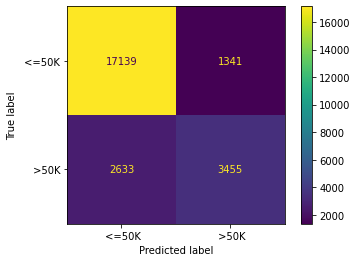

In [52]:
# Confusion Matrix for `y_train`

cm = confusion_matrix(y_train, logreg_pred_train, labels=logreg_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=logreg_model.classes_)

disp.plot()
plt.show()

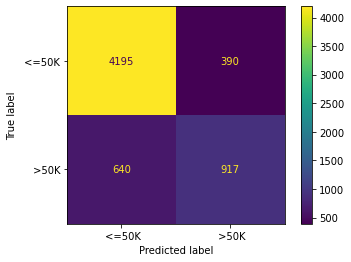

In [53]:
# Confusion Matrix for `y_test`

cm = confusion_matrix(y_test, logreg_pred_test, labels=logreg_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=logreg_model.classes_)

disp.plot()
plt.show()

In [54]:
# Classification Report for `y-train`

print(classification_report(y_train,logreg_pred_train))

              precision    recall  f1-score   support

       <=50K       0.87      0.93      0.90     18480
        >50K       0.72      0.57      0.63      6088

    accuracy                           0.84     24568
   macro avg       0.79      0.75      0.77     24568
weighted avg       0.83      0.84      0.83     24568



In [55]:
# Classification Report for `y-test`
print(classification_report(y_test,logreg_pred_test))

              precision    recall  f1-score   support

       <=50K       0.87      0.91      0.89      4585
        >50K       0.70      0.59      0.64      1557

    accuracy                           0.83      6142
   macro avg       0.78      0.75      0.77      6142
weighted avg       0.83      0.83      0.83      6142



Pada kelas <=50K pada data test, tingkat keberhasilan dalam memprediksi penduduk dengan kategori penghasilan dengan benar mencapai 87%, tingkat kegagalan masih cukup tinggi yaitu sebesar 13% penduduk yang diprediksi berada di kategori penghasilan <=50K ternyata bukan merupakan penduduk dalam kategori pendapatan tersebut (False Positive). Sementara itu terdapat 30% penduduk yang seharusnya masuk ke kelas pendapatan <=50K ternyata berdasarkan hasil prediksi berada pada kelas pendapatan >50K. 
<br>
<br>
Persentase kesalahan prediksi yang masih cukup tinggi tentu saja mengkhawatirkan apabila data kelas pendapatan ini kemudian akan digunakan sebagai acuan dalam memberikan bantuan finansial. Penduduk yang seharusnya tidak mendapatkan bantuan karena berpenghasilan tinggi justru menerima bantuan. Hal tersebut tentunya akan sangat merugikan karena bantuan menjadi tidak tepat sasaran.
<br>
<br>
Berdasarkan nilai akurasi antara data train data test, data masih tegolong good-fit. 

# **VII. SVM**

In [71]:
# Model Definition

model = SVC(C=10.0, kernel='rbf', degree=3, random_state=72)

In [72]:
# Model Training

model.fit(X_train_final, y_train)

SVC(C=10.0, random_state=72)

In [73]:
# Predict Train-Set and Test-Set 

y_pred_train = model.predict(X_train_final)
y_pred_test = model.predict(X_test_final)

In [74]:
# Classification Report for `y-train`
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

       <=50K       0.89      0.94      0.91     18480
        >50K       0.78      0.64      0.70      6088

    accuracy                           0.87     24568
   macro avg       0.83      0.79      0.81     24568
weighted avg       0.86      0.87      0.86     24568



In [75]:
# Classification Report for `y-test`
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

       <=50K       0.87      0.93      0.90      4585
        >50K       0.75      0.59      0.66      1557

    accuracy                           0.84      6142
   macro avg       0.81      0.76      0.78      6142
weighted avg       0.84      0.84      0.84      6142



Penggunaan model SVM dengan nilai C (Regularization parameter) sebesar 10 menghasilkan nilai precision yang lebih tinggi pada data train dibandingkan dengan model logistic regression. Namun untuk hasil tes justru tidak jauh berbeda, sehingga model tergolong overfit.

In [ ]:
#Hyperparameter Tuning using GridSearchCV
parameters = {
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'C': [0.5, 1, 10, 100],
    'gamma': ['scale', 1, 0.1, 0.01, 0.001]
}

grid_search = GridSearchCV(estimator=SVC(random_state=0),
                           param_grid=parameters,
                           n_jobs=6,
                           verbose=1,
                           scoring='accuracy')
grid_search.fit(X_train_final, y_train)

In [ ]:
print(f'Best Score: {grid_search.best_score_}')

best_params = grid_search.best_estimator_.get_params()
print(f'Best Parameters:')
for param in parameters:
  print(f'\t{param}: {best_params[param]}')

# **VII. Model Saving & Loading**

In [76]:
# Save the Files

import joblib
import json

with open('model_log_reg.pkl', 'wb') as file_1:
  joblib.dump(logreg_model, file_1)

with open('model_svm.pkl', 'wb') as file_2:
  joblib.dump(model, file_2)

with open('model_scaler.pkl', 'wb') as file_3:
  joblib.dump(scaler, file_3)

with open('model_encoder.pkl', 'wb') as file_4:
  joblib.dump(ohe, file_4)

with open('list_num_cols.txt', 'w') as file_5:
  json.dump(numerical, file_5)

with open('list_cat_cols.txt', 'w') as file_6:
  json.dump(categorical, file_6)

In [77]:
# Load All Files

import joblib
import json

with open('model_log_reg.pkl', 'rb') as file_1:
  logreg_model = joblib.load(file_1)

with open('model_svm.pkl', 'rb') as file_2:
  model = joblib.load(file_2)

with open('model_scaler.pkl', 'rb') as file_3:
  scaler = joblib.load(file_3)

with open('model_encoder.pkl', 'rb') as file_4:
  ohe = joblib.load(file_4)

with open('list_num_cols.txt', 'r') as file_5:
  numerical = json.load(file_5)

with open('list_cat_cols.txt', 'r') as file_6:
  categorical = json.load(file_6)

# **IX. Model Inference**

In [80]:
# Split between Numerical Columns and Categorical Columns

data_inf_num = data_inference[numerical]
data_inf_cat = data_inference[categorical]

data_inf_num.head()

,age,education_num,capital_gain,capital_loss,hours_per_week
0,39,9,0,0,40
1,21,5,0,0,50
2,27,13,0,0,40
3,28,6,0,0,35
4,21,10,0,0,40


In [ ]:
# Feature Scaling and Feature Encoding

data_inf_num_scaled = scaler.transform(data_inf_num)
data_inf_cat_encoded = ohe.transform(data_inf_cat)

data_inf_num_scaled

In [ ]:
# Concate Numerical Columns and Categorical Columns

data_inf_final = np.concatenate([data_inf_num_scaled, data_inf_cat_encoded], axis=1)
data_inf_final

**Logistic Regression**

In [84]:
# Predict using Logistic regression

y_pred_inf = logreg_model.predict(data_inf_final)
y_pred_inf

array([' <=50K', ' <=50K', ' <=50K', ' <=50K', ' <=50K', ' >50K',
       ' <=50K', ' >50K', ' <=50K', ' <=50K', ' <=50K', ' >50K', ' <=50K',
       ' >50K', ' <=50K'], dtype=object)

In [85]:
# Create DataFrame

y_pred_inf_df = pd.DataFrame(y_pred_inf, columns=['Income_Bracket_Prediction'])
y_pred_inf_df.head()

,Income_Bracket_Prediction
0,<=50K
1,<=50K
2,<=50K
3,<=50K
4,<=50K


In [86]:
# Concate between Inference-Set and Rating's Prediction

fin = pd.concat([data_inference, y_pred_inf_df], axis=1)
fin.head()

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket,Income_Bracket_Prediction
0,39,Private,9,Never-married,Farming-fishing,Unmarried,White,Male,0,0,40,United-States,<=50K,<=50K
1,21,Private,5,Never-married,Other-service,Own-child,White,Female,0,0,50,Mexico,<=50K,<=50K
2,27,Private,13,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K,<=50K
3,28,Private,6,Never-married,Farming-fishing,Other-relative,White,Male,0,0,35,Mexico,<=50K,<=50K
4,21,Private,10,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,40,United-States,<=50K,<=50K


**SVM**

In [87]:
# Predict using SVM

y_pred_inf_svm = model.predict(data_inf_final)
y_pred_inf_svm

array([' <=50K', ' <=50K', ' <=50K', ' <=50K', ' <=50K', ' >50K',
       ' <=50K', ' >50K', ' >50K', ' <=50K', ' <=50K', ' >50K', ' <=50K',
       ' <=50K', ' <=50K'], dtype=object)

In [88]:
# Create DataFrame

y_pred_inf_svm_df = pd.DataFrame(y_pred_inf_svm, columns=['Income_Bracket_Prediction'])
y_pred_inf_svm_df.head()

,Income_Bracket_Prediction
0,<=50K
1,<=50K
2,<=50K
3,<=50K
4,<=50K


In [90]:
# Concate between Inference-Set and Rating's Prediction

fin2 = pd.concat([data_inference, y_pred_inf_svm_df], axis=1)
fin2.tail()

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket,Income_Bracket_Prediction
10,40,Self-emp-not-inc,13,Married-civ-spouse,Sales,Husband,White,Male,0,0,45,United-States,>50K,<=50K
11,54,Local-gov,10,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,52,United-States,<=50K,>50K
12,54,Private,10,Married-civ-spouse,Tech-support,Husband,White,Male,0,1977,18,United-States,>50K,<=50K
13,38,Private,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,60,United-States,>50K,<=50K
14,20,Private,10,Never-married,Handlers-cleaners,Own-child,White,Male,0,0,20,United-States,<=50K,<=50K


# **X. Kesimpulan**

Pada `census_adult_income` yang digunakan untuk memprediksi kelompok penghasilan, data `income_bracket` yang merupakan target memiliki 2 kelas saja (<=50K dan >50K) membuatnya termasuk ke dalam jenis data categorical. Metode Logistic Regression cocok untuk memprediksi tipe data dengan jenis data ini. Target yang memiliki 2 kelas juga cocok jika diprediksi menggunakan SVM. 
<br>
<br>
Nilai precision dipilih dalam evaluasi model karena tidak menginginkan nilai false positive. Jika dibandingkan antara keduanya, penggunaan SVM meningkatkan nilai precision pada data train dibandingkan dengan logistic regression namun untuk data test tidak terlalu ada perbedaan.
<br>
<br>
Adapun selama proses pengerjaan model, pemilihan SVC seperti yang dilakukan kurang cocok untuk dataset yang besar seperti data ini. 



# **Menjawab Pertanyaan**

1. Apakah yang dimaksud dengan coeficient pada logistic regression?
  <br>**Jawab:** Dalam logistic regression, sulit untuk menginterpretasikan nikai coefficient karena bentuk persamaannya yang merupakan logaritma natural dari probabilitas logistik sehingga digunakan *Odds Ratio*. 

2. Apakah yang dimaksud dengan Support Vector pada SVM?
  <br>**Jawab:** Super Vector adalah Data yang paling mendekati hyperplane. Pembentukan hyperplane akan sangat dipengaruhi oleh data yang paling dekat dengan hyperplane.

3. Apakah fungsi parameter kernel pada SVM? Jelaskan salah satu kernel yang kalian pahami!
  <br>**Jawab:** Kernel berfungsi untuk menentukan jenis/bentuk separator. Adapun bentuk separator tersebut terdiri atas Linear untuk garis lurus (tidak dipetakan ke dimensi yang lebih tinggi), polinomial untuk berliku/meliuk, dan untuk defaultnya adalah rbf function untuk memetakan ke ruang infinite.